# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

# Set numpy print precision to get a prettier print result
np.set_printoptions(precision=3)

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


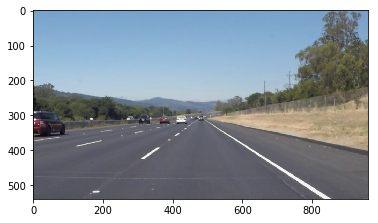

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    # Try simple clustering first 
    left_lines = []        # lines whose slope < 0
    right_lines = []       # lines whose slope > 0
    
    # Split lines into two classes (left and right)
    for idx, line in enumerate(lines):
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)
            if slope < 0:
                left_lines.append([x1, y1, x2, y2, slope])
            elif slope > 0:
                right_lines.append([x1, y1, x2, y2, slope])
            else:   # slope == 0   =>  drop all horizontal lines
                continue
    
    # Numpy array is easier to handle than list
    left_lines = np.asarray(left_lines)
    right_lines = np.asarray(right_lines)
    
    # Exclude outliers in terms of slope from both classes
    left_lines = left_lines[abs(left_lines[:,4] - np.mean(left_lines[:,4])) < np.std(left_lines[:,4])]
    right_lines = right_lines[abs(right_lines[:,4] - np.mean(right_lines[:,4])) < np.std(right_lines[:,4])]
    
    # Compute average position and average slope of both classes
    left_lines_mean = np.mean(left_lines, axis=0)
    right_lines_mean = np.mean(right_lines, axis=0) 
    
    # Compute b of left line and right line (y = mx + b  =>  b = y - mx)
    left_mean_x1 = left_lines_mean[0]
    left_mean_y1 = left_lines_mean[1]
    left_m = left_lines_mean[4]
    right_mean_x1 = right_lines_mean[0]
    right_mean_y1 = right_lines_mean[1]
    right_m = right_lines_mean[4]
    
    left_b = left_mean_y1 - left_m * left_mean_x1
    right_b = right_mean_y1 - right_m * right_mean_x1
    
    # Compute starting point and end point of both lines (y = mx + b)
    left_x1 = 0
    left_y1 = left_m * left_x1 + left_b
    left_x2 = 959
    left_y2 = left_m * left_x2 + left_b
    
    right_x1 = 0
    right_y1 = right_m * right_x1 + right_b
    right_x2 = 959
    right_y2 = right_m * right_x2 + right_b
    
    # Draw these two lines
    try:
        cv2.line(img, (int(left_x1), int(left_y1)), (int(left_x2), int(left_y2)), color, thickness)
        cv2.line(img, (int(right_x1), int(right_y1)), (int(right_x2), int(right_y2)), color, thickness)
    except:
        print('unexcepted error')
        print(left_x1, left_y1, left_x2, left_y2, left_m, left_b)
        print(right_x1, right_y1, right_x2, right_y2, right_m, right_b)
    

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support or cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

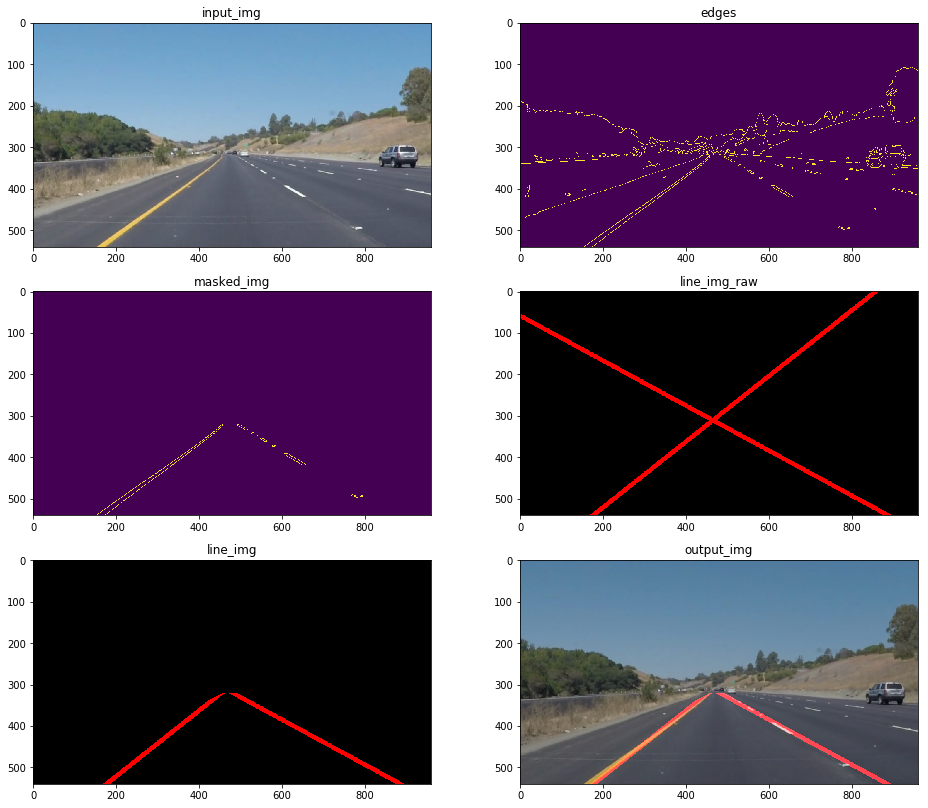

In [11]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

def lane_finding_pipeline(img, kernel_size=5, 
                          canny_low_threshold=50, canny_high_threshold=150, vertices=None, 
                          rho=1, theta=np.pi/180, hough_threshold=5, min_line_len=10, max_line_gap=20):
    '''
    Find lane lines on input image and highlight them in red
    
    Inputs:
    - img: Input image pixel array, default shape is (960, 540, 3)
    - kernel_size: kernel size for Gaussian smoothing
    - canny_low_threshold: low threshold of canny edge detector
    - canny_high_threshold: high threshold of canny edge detector
    - vertices: vertice coordinates defining image mask polygon, 
                should be a numpy array with such a shape:
                np.array([[(X1, Y1), (X2, Y2), (X3, Y3), ...]], dtype=np.int32)
    - rho: distance resolution in pixels of the Hough grid
    - theta: angular resolution in radians of the Hough grid
    - hough_threshold: minimum number of votes (intersections in Hough grid cell)
    - min_line_len: minimum number of pixels making up a line
    - max_line_gap: maximum gap in pixels between connectable line segments
    
    Output:
    - output_img: the input image with lane lines highlighted in red
    '''
    
    # Grayscale the input image
    gray = grayscale(img)
    
    # Apply Gaussian smoothing 
    blur_gray = gaussian_blur(gray, kernel_size)

    # Highlight edges by canny edge detector
    edges = canny(blur_gray, canny_low_threshold, canny_high_threshold)
        
    # Apply an image mask to only highlight lane lines in the mask region
    if vertices is None: # Set default value to vertices
        img_shape = image.shape
        vertices = np.array([[(0,img_shape[0]),(img_shape[1]/2-20, img_shape[0]/2+50), 
                              (img_shape[1]/2+20, img_shape[0]/2+50), (img_shape[1],img_shape[0])]], 
                            dtype=np.int32)
    
    masked_img = region_of_interest(edges, vertices)
        
    # Run Hough on masked and edge detected image to highlight all lines in the masked region in red
    line_img_raw = hough_lines(masked_img, rho, theta, hough_threshold, min_line_len, max_line_gap)
    
    # Apply the image mask once more to exclude the part of lane lines which is not in mask region
    line_img = region_of_interest(line_img_raw, vertices)
        
    # Draw the highlighted red lines on the initial image
    output_img = weighted_img(line_img, img)
        
    # Return output image
    return edges, masked_img, line_img_raw, line_img, output_img
    
    
# Test lane_finding_pipeline function with test images
# Read input image as numpy array
input_img = mpimg.imread("test_images/solidYellowCurve.jpg")
edges, masked_img, line_img_raw, line_img, output_img = lane_finding_pipeline(input_img)

# Print output images in a 2*2 grid for test purpose
plt.close('all')

f, axarr = plt.subplots(3, 2, figsize=(16, 14))
axarr[0, 0].imshow(input_img)
axarr[0, 0].set_title('input_img')
axarr[0, 1].imshow(edges)
axarr[0, 1].set_title('edges')
axarr[1, 0].imshow(masked_img)
axarr[1, 0].set_title('masked_img')
axarr[1, 1].imshow(line_img_raw)
axarr[1, 1].set_title('line_img_raw')
axarr[2, 0].imshow(line_img)
axarr[2, 0].set_title('line_img')
axarr[2, 1].imshow(output_img)
axarr[2, 1].set_title('output_img')


plt.show()


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [12]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [13]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    _, _, _, _, result = lane_finding_pipeline(image)
    
    return result

Let's try the one with the solid white lane on the right first ...

In [14]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:07<00:00, 30.68it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 8.19 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [16]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


  2%|▏         | 12/682 [00:00<00:13, 49.49it/s]

unexcepted error
0 636.200267662 959 -22.3192917648 -0.686673158944 636.200267662
0 nan 959 nan nan nan


 10%|▉         | 66/682 [00:01<00:24, 25.01it/s]

unexcepted error
0 622.902951648 959 87.4415247319 -0.558353938391 622.902951648
0 nan 959 nan nan nan


 13%|█▎        | 90/682 [00:03<00:24, 23.71it/s]

unexcepted error
0 nan 959 nan nan nan
0 -10.4644200207 959 617.99002741 0.655322677196 -10.4644200207


 30%|███       | 207/682 [00:06<00:14, 32.07it/s]

unexcepted error
0 nan 959 nan nan nan
0 81.6420148135 959 562.345703463 0.501255149791 81.6420148135


 53%|█████▎    | 363/682 [00:12<00:15, 21.27it/s]

unexcepted error
0 nan 959 nan nan nan
0 66.2376724012 959 650.03785982 0.608759319519 66.2376724012


 66%|██████▌   | 448/682 [00:15<00:07, 30.60it/s]

unexcepted error
0 nan 959 nan nan nan
0 57.1311708135 959 611.577970285 0.578150990064 57.1311708135


 68%|██████▊   | 463/682 [00:16<00:09, 22.94it/s]

unexcepted error
0 nan 959 nan nan nan
0 39.4600027498 959 585.709906373 0.569603653413 39.4600027498


 73%|███████▎  | 497/682 [00:17<00:08, 21.99it/s]

unexcepted error
0 nan 959 nan nan nan
0 27.5198394914 959 598.26056777 0.595141531052 27.5198394914


 85%|████████▌ | 583/682 [00:21<00:04, 22.40it/s]

unexcepted error
0 nan 959 nan nan nan
0 27.5507781432 959 586.356572209 0.582696344177 27.5507781432


 88%|████████▊ | 597/682 [00:21<00:04, 20.78it/s]

unexcepted error
0 nan 959 nan nan nan
0 92.6440278286 959 606.683496929 0.536016130448 92.6440278286


 93%|█████████▎| 634/682 [00:23<00:02, 20.61it/s]

unexcepted error
0 nan 959 nan nan nan
0 74.4662777062 959 599.135688713 0.547100532854 74.4662777062


100%|█████████▉| 681/682 [00:25<00:00, 28.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 26.1 s


In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [18]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

unexcepted error
0 nan 959 nan nan nan
0 198.186129454 959 583.002272452 0.401268136598 198.186129454
[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


  0%|          | 0/251 [00:00<?, ?it/s]

unexcepted error
0 nan 959 nan nan nan
0 198.186129454 959 583.002272452 0.401268136598 198.186129454


  0%|          | 1/251 [00:00<00:28,  8.77it/s]

unexcepted error
0 601.081635091 959 277.583316835 -0.337328799016 601.081635091
0 nan 959 nan nan nan


  1%|          | 2/251 [00:00<00:27,  8.98it/s]

unexcepted error
0 nan 959 nan nan nan
0 124.764959695 959 598.843316877 0.494346566404 124.764959695


  2%|▏         | 4/251 [00:00<00:24,  9.93it/s]

unexcepted error
0 nan 959 nan nan nan
0 159.913811045 959 601.272373368 0.460227906489 159.913811045


  2%|▏         | 6/251 [00:00<00:22, 10.97it/s]

unexcepted error
0 nan 959 nan nan nan
0 -6.28174182802 959 704.310226186 0.740971812319 -6.28174182802


  3%|▎         | 7/251 [00:00<00:24,  9.87it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan
unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


  4%|▎         | 9/251 [00:00<00:24,  9.98it/s]

unexcepted error
0 nan 959 nan nan nan
0 120.569891322 959 606.287033363 0.506482942692 120.569891322


  4%|▍         | 11/251 [00:00<00:22, 10.61it/s]

unexcepted error
0 nan 959 nan nan nan
0 146.094774117 959 630.472820014 0.505086596347 146.094774117


  5%|▌         | 13/251 [00:01<00:21, 11.24it/s]

unexcepted error
0 nan 959 nan nan nan
0 109.247673319 959 630.575188182 0.543615761067 109.247673319


  6%|▌         | 15/251 [00:01<00:21, 11.22it/s]

unexcepted error
0 645.265934845 959 223.933892078 -0.439345195794 645.265934845
0 nan 959 nan nan nan
unexcepted error
0 nan 959 nan nan nan
0 59.6510787051 959 623.596878345 0.588056099728 59.6510787051


  7%|▋         | 17/251 [00:01<00:23,  9.97it/s]

unexcepted error
0 nan 959 nan nan nan
0 78.3279696348 959 638.667886019 0.584296054624 78.3279696348


  8%|▊         | 19/251 [00:01<00:23,  9.95it/s]

unexcepted error
0 nan 959 nan nan nan
0 90.9076345505 959 633.838965922 0.566143202682 90.9076345505
unexcepted error
0 nan 959 nan nan nan
0 5.95283749605 959 688.552949426 0.711783224119 5.95283749605


  8%|▊         | 21/251 [00:02<00:24,  9.39it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


  9%|▉         | 22/251 [00:02<00:24,  9.17it/s]

unexcepted error
0 nan 959 nan nan nan
0 145.345016712 959 599.728823937 0.473810017961 145.345016712


  9%|▉         | 23/251 [00:02<00:25,  8.88it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 10%|▉         | 24/251 [00:02<00:25,  8.82it/s]

unexcepted error
0 nan 959 nan nan nan
0 18.3397419502 959 697.095675657 0.707774696253 18.3397419502


 10%|▉         | 25/251 [00:02<00:25,  8.81it/s]

unexcepted error
0 nan 959 nan nan nan
0 28.8789246156 959 696.933513777 0.696615838542 28.8789246156


 10%|█         | 26/251 [00:02<00:26,  8.44it/s]

unexcepted error
0 718.848322381 959 183.52384467 -0.558211134214 718.848322381
0 nan 959 nan nan nan


 11%|█         | 27/251 [00:02<00:27,  8.14it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 11%|█         | 28/251 [00:02<00:26,  8.38it/s]

unexcepted error
0 nan 959 nan nan nan
0 33.7431068152 959 675.046943779 0.668721414978 33.7431068152


 12%|█▏        | 29/251 [00:02<00:27,  8.16it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 12%|█▏        | 30/251 [00:03<00:29,  7.56it/s]

unexcepted error
0 nan 959 nan nan nan
0 63.5167045114 959 655.32260642 0.61710730126 63.5167045114


 12%|█▏        | 31/251 [00:03<00:29,  7.53it/s]

unexcepted error
0 nan 959 nan nan nan
0 31.6813443408 959 675.802936378 0.671659637161 31.6813443408


 13%|█▎        | 32/251 [00:03<00:28,  7.58it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 13%|█▎        | 33/251 [00:03<00:27,  7.83it/s]

unexcepted error
0 639.849616483 959 249.954129728 -0.406564636867 639.849616483
0 nan 959 nan nan nan


 14%|█▍        | 35/251 [00:03<00:25,  8.44it/s]

unexcepted error
0 nan 959 nan nan nan
0 104.659626913 959 635.244658052 0.55326906271 104.659626913


 14%|█▍        | 36/251 [00:03<00:26,  8.24it/s]

unexcepted error
0 nan 959 nan nan nan
0 134.624727378 959 610.495608895 0.496215726294 134.624727378


 15%|█▍        | 37/251 [00:03<00:25,  8.46it/s]

unexcepted error
0 nan 959 nan nan nan
0 2.69590521869 959 687.438725316 0.714017539205 2.69590521869


 15%|█▌        | 38/251 [00:04<00:24,  8.68it/s]

unexcepted error
0 nan 959 nan nan nan
0 54.4573719505 959 664.270878788 0.635884782938 54.4573719505


 16%|█▌        | 40/251 [00:04<00:22,  9.41it/s]

unexcepted error
0 698.878811753 959 173.192024403 -0.548161404954 698.878811753
0 nan 959 nan nan nan


 16%|█▋        | 41/251 [00:04<00:22,  9.36it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 17%|█▋        | 42/251 [00:04<00:23,  9.05it/s]

unexcepted error
0 nan 959 nan nan nan
0 71.8276193762 959 629.175395228 0.581175991504 71.8276193762


 17%|█▋        | 43/251 [00:04<00:23,  8.92it/s]

unexcepted error
0 nan 959 nan nan nan
0 6.45247721981 959 709.710892714 0.7333247294 6.45247721981


 18%|█▊        | 44/251 [00:04<00:24,  8.49it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 18%|█▊        | 45/251 [00:04<00:24,  8.51it/s]

unexcepted error
0 nan 959 nan nan nan
0 -39.3274204447 959 723.908635896 0.795866586382 -39.3274204447


 18%|█▊        | 46/251 [00:04<00:24,  8.43it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 19%|█▊        | 47/251 [00:05<00:24,  8.18it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 19%|█▉        | 48/251 [00:05<00:24,  8.26it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 20%|█▉        | 49/251 [00:05<00:25,  7.99it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 20%|█▉        | 50/251 [00:05<00:24,  8.09it/s]

unexcepted error
0 nan 959 nan nan nan
0 49.7788052953 959 702.774688599 0.680913329826 49.7788052953


 20%|██        | 51/251 [00:05<00:25,  7.72it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 21%|██        | 52/251 [00:05<00:35,  5.62it/s]

unexcepted error
0 854.019292207 959 5.46186828614 -0.884835687091 854.019292207
0 nan 959 nan nan nan


 21%|██        | 53/251 [00:06<00:37,  5.29it/s]

unexcepted error
0 nan 959 nan nan nan
0 -28.1329982923 959 769.875591551 0.832125745405 -28.1329982923


 22%|██▏       | 54/251 [00:06<00:35,  5.56it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 22%|██▏       | 55/251 [00:06<00:31,  6.17it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 22%|██▏       | 56/251 [00:06<00:33,  5.87it/s]

unexcepted error
0 nan 959 nan nan nan
0 55.7264122512 959 701.953531194 0.67385518138 55.7264122512


 23%|██▎       | 57/251 [00:06<00:31,  6.21it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 23%|██▎       | 58/251 [00:06<00:29,  6.49it/s]

unexcepted error
0 nan 959 nan nan nan
0 71.7793282204 959 659.824082269 0.613185353544 71.7793282204


 24%|██▎       | 59/251 [00:07<00:35,  5.48it/s]

unexcepted error
0 nan 959 nan nan nan
0 -57.6487208611 959 803.780623146 0.898257918673 -57.6487208611


 24%|██▍       | 60/251 [00:07<00:32,  5.92it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 24%|██▍       | 61/251 [00:07<00:33,  5.62it/s]

unexcepted error
0 nan 959 nan nan nan
0 -22.1146606704 959 744.392753209 0.799277803836 -22.1146606704


 25%|██▍       | 62/251 [00:07<00:30,  6.21it/s]

unexcepted error
0 nan 959 nan nan nan
0 -164.997746424 959 921.842756681 1.1333060512 -164.997746424


 25%|██▌       | 63/251 [00:07<00:29,  6.38it/s]

unexcepted error
0 nan 959 nan nan nan
0 -12.5813229997 959 746.165360174 0.791185279638 -12.5813229997


 25%|██▌       | 64/251 [00:07<00:31,  6.02it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 26%|██▌       | 65/251 [00:08<00:30,  6.06it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 26%|██▋       | 66/251 [00:08<00:32,  5.66it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 27%|██▋       | 67/251 [00:08<00:30,  6.07it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 27%|██▋       | 68/251 [00:08<00:30,  5.90it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 27%|██▋       | 69/251 [00:08<00:28,  6.34it/s]

unexcepted error
0 nan 959 nan nan nan
0 24.9705924516 959 794.199176158 0.802115311477 24.9705924516


 28%|██▊       | 70/251 [00:08<00:29,  6.04it/s]

unexcepted error
0 nan 959 nan nan nan
0 62.1614800881 959 722.571933425 0.688644893991 62.1614800881


 28%|██▊       | 71/251 [00:09<00:27,  6.55it/s]

unexcepted error
0 nan 959 nan nan nan
0 -171.293710386 959 953.0455834 1.17240802272 -171.293710386


 29%|██▊       | 72/251 [00:09<00:33,  5.40it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 29%|██▉       | 73/251 [00:09<00:32,  5.55it/s]

unexcepted error
0 nan 959 nan nan nan
0 -43.8970907057 959 863.967077509 0.94667796477 -43.8970907057


 29%|██▉       | 74/251 [00:09<00:29,  6.02it/s]

unexcepted error
0 nan 959 nan nan nan
0 -40.613664881 959 851.973161459 0.930747472722 -40.613664881


 30%|██▉       | 75/251 [00:09<00:27,  6.49it/s]

unexcepted error
0 nan 959 nan nan nan
0 53.0239724725 959 748.772675756 0.725493955458 53.0239724725


 30%|███       | 76/251 [00:09<00:27,  6.42it/s]

unexcepted error
0 nan 959 nan nan nan
0 -123.233316498 959 945.584958165 1.11451332082 -123.233316498


 31%|███       | 77/251 [00:10<00:30,  5.71it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 31%|███       | 78/251 [00:10<00:31,  5.52it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 31%|███▏      | 79/251 [00:10<00:29,  5.80it/s]

unexcepted error
0 nan 959 nan nan nan
0 -5.04076705099 959 873.214809689 0.915803521105 -5.04076705099


 32%|███▏      | 80/251 [00:10<00:27,  6.16it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 32%|███▏      | 81/251 [00:10<00:27,  6.13it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 33%|███▎      | 82/251 [00:10<00:29,  5.68it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 33%|███▎      | 83/251 [00:11<00:26,  6.26it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 33%|███▎      | 84/251 [00:11<00:28,  5.81it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 34%|███▍      | 85/251 [00:11<00:26,  6.28it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 34%|███▍      | 86/251 [00:11<00:29,  5.64it/s]

unexcepted error
0 nan 959 nan nan nan
0 34.3907476171 959 866.938877675 0.868141950008 34.3907476171


 35%|███▍      | 87/251 [00:11<00:27,  6.01it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 35%|███▌      | 88/251 [00:11<00:25,  6.34it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 35%|███▌      | 89/251 [00:12<00:26,  6.06it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 36%|███▌      | 90/251 [00:12<00:26,  6.15it/s]

unexcepted error
0 nan 959 nan nan nan
0 -21.2230886592 959 970.830133202 1.03446634188 -21.2230886592


 36%|███▋      | 91/251 [00:12<00:27,  5.72it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 37%|███▋      | 92/251 [00:12<00:29,  5.37it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 37%|███▋      | 93/251 [00:12<00:27,  5.69it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 37%|███▋      | 94/251 [00:12<00:25,  6.11it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 38%|███▊      | 95/251 [00:13<00:25,  6.10it/s]

unexcepted error
0 nan 959 nan nan nan
0 -80.4526375876 959 1051.24381924 1.18007972558 -80.4526375876


 38%|███▊      | 96/251 [00:13<00:24,  6.42it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 39%|███▊      | 97/251 [00:13<00:25,  6.06it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 39%|███▉      | 98/251 [00:13<00:30,  5.06it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 39%|███▉      | 99/251 [00:13<00:26,  5.63it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 40%|███▉      | 100/251 [00:13<00:26,  5.65it/s]

unexcepted error
0 nan 959 nan nan nan
0 -55.9937612955 959 1070.47763728 1.1746312811 -55.9937612955


 40%|████      | 101/251 [00:14<00:24,  6.06it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 41%|████      | 102/251 [00:14<00:22,  6.52it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 41%|████      | 103/251 [00:14<00:24,  6.14it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 41%|████▏     | 104/251 [00:14<00:28,  5.19it/s]

unexcepted error
0 nan 959 nan nan nan
0 10.2394108787 959 925.026022874 0.953896362874 10.2394108787


 42%|████▏     | 105/251 [00:14<00:26,  5.59it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 42%|████▏     | 106/251 [00:15<00:27,  5.31it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 43%|████▎     | 107/251 [00:15<00:27,  5.21it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 43%|████▎     | 108/251 [00:15<00:25,  5.57it/s]

unexcepted error
0 nan 959 nan nan nan
0 80.2189096948 959 871.657126769 0.825274470359 80.2189096948


 43%|████▎     | 109/251 [00:15<00:24,  5.90it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 44%|████▍     | 110/251 [00:15<00:25,  5.46it/s]

unexcepted error
0 nan 959 nan nan nan
0 -8.58140318545 959 884.246069289 0.930998407168 -8.58140318545


 44%|████▍     | 111/251 [00:15<00:26,  5.29it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 45%|████▍     | 112/251 [00:16<00:23,  5.96it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 45%|████▌     | 113/251 [00:16<00:24,  5.54it/s]

unexcepted error
0 nan 959 nan nan nan
0 2.30060467625 959 846.574866032 0.880369407045 2.30060467625


 45%|████▌     | 114/251 [00:16<00:24,  5.52it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 46%|████▌     | 115/251 [00:16<00:24,  5.48it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 46%|████▌     | 116/251 [00:16<00:24,  5.41it/s]

unexcepted error
0 nan 959 nan nan nan
0 59.7247752337 959 756.040340623 0.726085052543 59.7247752337


 47%|████▋     | 117/251 [00:16<00:22,  5.89it/s]

unexcepted error
0 nan 959 nan nan nan
0 21.5675985887 959 886.663391407 0.902081118685 21.5675985887


 47%|████▋     | 118/251 [00:17<00:25,  5.31it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 47%|████▋     | 119/251 [00:17<00:24,  5.38it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 48%|████▊     | 120/251 [00:17<00:28,  4.60it/s]

unexcepted error
0 nan 959 nan nan nan
0 -0.968343419578 959 797.726272122 0.832841100669 -0.968343419578


 48%|████▊     | 121/251 [00:17<00:24,  5.21it/s]

unexcepted error
0 nan 959 nan nan nan
0 -11.0169021206 959 879.077047434 0.928148018306 -11.0169021206


 49%|████▊     | 122/251 [00:17<00:23,  5.50it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 49%|████▉     | 123/251 [00:18<00:21,  5.89it/s]

unexcepted error
0 701.058122722 959 19.614239866 -0.710577562936 701.058122722
0 nan 959 nan nan nan


 49%|████▉     | 124/251 [00:18<00:20,  6.13it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 50%|████▉     | 125/251 [00:18<00:23,  5.43it/s]

unexcepted error
0 nan 959 nan nan nan
0 111.349114308 959 782.74874485 0.700103890033 111.349114308


 50%|█████     | 126/251 [00:18<00:26,  4.72it/s]

unexcepted error
0 nan 959 nan nan nan
0 94.5615286859 959 732.579282373 0.665294842218 94.5615286859


 51%|█████     | 127/251 [00:18<00:26,  4.75it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 51%|█████     | 128/251 [00:19<00:23,  5.32it/s]

unexcepted error
0 nan 959 nan nan nan
0 -4.5963456415 959 844.119445526 0.885000824992 -4.5963456415


 51%|█████▏    | 129/251 [00:19<00:23,  5.24it/s]

unexcepted error
0 nan 959 nan nan nan
0 141.229575921 959 753.250328067 0.638186394312 141.229575921


 52%|█████▏    | 130/251 [00:19<00:22,  5.40it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 52%|█████▏    | 131/251 [00:19<00:21,  5.51it/s]

unexcepted error
0 nan 959 nan nan nan
0 179.533719857 959 831.179771587 0.679505789082 179.533719857


 53%|█████▎    | 132/251 [00:19<00:24,  4.94it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 53%|█████▎    | 133/251 [00:20<00:26,  4.49it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 53%|█████▎    | 134/251 [00:20<00:23,  4.88it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 54%|█████▍    | 135/251 [00:20<00:24,  4.69it/s]

unexcepted error
0 nan 959 nan nan nan
0 50.5431959671 959 823.773453492 0.806288068326 50.5431959671


 55%|█████▍    | 137/251 [00:20<00:20,  5.47it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 55%|█████▍    | 138/251 [00:21<00:20,  5.41it/s]

unexcepted error
0 nan 959 nan nan nan
0 130.78420834 959 792.667127827 0.690180312291 130.78420834


 55%|█████▌    | 139/251 [00:21<00:22,  4.90it/s]

unexcepted error
0 nan 959 nan nan nan
0 84.0312140305 959 873.835657578 0.823570848329 84.0312140305


 56%|█████▌    | 140/251 [00:21<00:21,  5.21it/s]

unexcepted error
0 nan 959 nan nan nan
0 64.6396242861 959 850.729846099 0.819697832964 64.6396242861


 56%|█████▌    | 141/251 [00:21<00:22,  4.94it/s]

unexcepted error
0 nan 959 nan nan nan
0 207.258068517 959 735.186628664 0.550499019967 207.258068517


 57%|█████▋    | 142/251 [00:21<00:21,  5.13it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 57%|█████▋    | 143/251 [00:22<00:30,  3.59it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 57%|█████▋    | 144/251 [00:22<00:24,  4.39it/s]

unexcepted error
0 nan 959 nan nan nan
0 231.896412019 959 669.920676605 0.456751057962 231.896412019


 58%|█████▊    | 145/251 [00:23<00:54,  1.93it/s]

unexcepted error
0 nan 959 nan nan nan
0 267.830566424 959 667.463328517 0.416718208647 267.830566424


 58%|█████▊    | 146/251 [00:23<00:46,  2.28it/s]

unexcepted error
0 656.644775062 959 222.729956945 -0.452465920873 656.644775062
0 nan 959 nan nan nan


 59%|█████▉    | 148/251 [00:24<00:28,  3.62it/s]

unexcepted error
0 nan 959 nan nan nan
0 85.889268328 959 736.852536268 0.678793814327 85.889268328


 60%|█████▉    | 150/251 [00:24<00:22,  4.43it/s]

unexcepted error
0 nan 959 nan nan nan
0 181.177941976 959 639.233609407 0.47763886072 181.177941976


 61%|██████    | 153/251 [00:24<00:19,  5.14it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 61%|██████▏   | 154/251 [00:24<00:16,  5.84it/s]

unexcepted error
0 nan 959 nan nan nan
0 166.056451019 959 674.913581099 0.530612231574 166.056451019


 62%|██████▏   | 155/251 [00:25<00:16,  5.83it/s]

unexcepted error
0 nan 959 nan nan nan
0 276.725662687 959 612.917681689 0.350565191869 276.725662687


 62%|██████▏   | 156/251 [00:25<00:15,  6.19it/s]

unexcepted error
0 nan 959 nan nan nan
0 212.53836535 959 665.120940842 0.471931778406 212.53836535


 63%|██████▎   | 158/251 [00:25<00:15,  5.81it/s]

unexcepted error
0 nan 959 nan nan nan
0 177.086312623 959 629.294879641 0.471541779998 177.086312623


 64%|██████▍   | 161/251 [00:25<00:15,  5.96it/s]

unexcepted error
0 nan 959 nan nan nan
0 209.734084037 959 580.132305922 0.386233808014 209.734084037


 65%|██████▍   | 162/251 [00:26<00:15,  5.68it/s]

unexcepted error
0 577.690367001 959 240.46657219 -0.351641079051 577.690367001
0 nan 959 nan nan nan


 65%|██████▌   | 164/251 [00:26<00:14,  5.93it/s]

unexcepted error
0 694.874368746 959 151.037141198 -0.567087828518 694.874368746
0 nan 959 nan nan nan


 67%|██████▋   | 167/251 [00:26<00:11,  7.03it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 68%|██████▊   | 170/251 [00:27<00:10,  7.42it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 68%|██████▊   | 171/251 [00:27<00:13,  6.12it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 69%|██████▊   | 172/251 [00:27<00:13,  5.98it/s]

unexcepted error
0 nan 959 nan nan nan
0 36.6323559863 959 691.710099126 0.683084195141 36.6323559863


 69%|██████▉   | 173/251 [00:27<00:12,  6.39it/s]

unexcepted error
0 nan 959 nan nan nan
0 144.329122768 959 673.653327339 0.55195433219 144.329122768


 69%|██████▉   | 174/251 [00:27<00:13,  5.66it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 70%|██████▉   | 175/251 [00:28<00:12,  5.85it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 70%|███████   | 176/251 [00:28<00:14,  5.33it/s]

unexcepted error
0 nan 959 nan nan nan
0 75.1659581675 959 653.947733425 0.603526355847 75.1659581675


 71%|███████   | 177/251 [00:28<00:16,  4.59it/s]

unexcepted error
0 nan 959 nan nan nan
0 187.030420057 959 613.716268957 0.444927892492 187.030420057


 71%|███████   | 178/251 [00:28<00:14,  5.08it/s]

unexcepted error
0 nan 959 nan nan nan
0 144.246544228 959 628.840744228 0.505311991657 144.246544228


 72%|███████▏  | 180/251 [00:29<00:12,  5.49it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 72%|███████▏  | 181/251 [00:29<00:13,  5.02it/s]

unexcepted error
0 nan 959 nan nan nan
0 109.135333038 959 621.802685736 0.534585352136 109.135333038


 73%|███████▎  | 182/251 [00:29<00:13,  5.29it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 73%|███████▎  | 183/251 [00:29<00:13,  5.21it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 73%|███████▎  | 184/251 [00:29<00:12,  5.36it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 74%|███████▍  | 186/251 [00:30<00:11,  5.90it/s]

unexcepted error
0 nan 959 nan nan nan
0 -1.38384901652 959 746.019204225 0.779356676999 -1.38384901652


 75%|███████▍  | 188/251 [00:30<00:11,  5.55it/s]

unexcepted error
0 nan 959 nan nan nan
0 24.4773057829 959 740.335581392 0.746463269666 24.4773057829


 75%|███████▌  | 189/251 [00:30<00:10,  5.87it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 76%|███████▌  | 190/251 [00:30<00:10,  5.90it/s]

unexcepted error
0 nan 959 nan nan nan
0 77.5865331256 959 680.196978964 0.628373770426 77.5865331256


 76%|███████▌  | 191/251 [00:31<00:12,  4.89it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 76%|███████▋  | 192/251 [00:31<00:11,  5.13it/s]

unexcepted error
0 nan 959 nan nan nan
0 -37.7107239005 959 759.985323922 0.831799841317 -37.7107239005


 77%|███████▋  | 193/251 [00:31<00:11,  4.85it/s]

unexcepted error
0 nan 959 nan nan nan
0 166.367021698 959 587.239599893 0.438866087794 166.367021698


 78%|███████▊  | 195/251 [00:31<00:10,  5.48it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 78%|███████▊  | 196/251 [00:32<00:09,  5.54it/s]

unexcepted error
0 682.229353182 959 177.932653529 -0.52585682967 682.229353182
0 nan 959 nan nan nan


 78%|███████▊  | 197/251 [00:32<00:09,  5.80it/s]

unexcepted error
0 nan 959 nan nan nan
0 160.846717139 959 651.063009442 0.511174444528 160.846717139


 79%|███████▉  | 199/251 [00:32<00:07,  6.63it/s]

unexcepted error
0 nan 959 nan nan nan
0 -10.1498954104 959 767.652854838 0.811056048225 -10.1498954104


 80%|████████  | 202/251 [00:32<00:08,  5.96it/s]

unexcepted error
0 nan 959 nan nan nan
0 179.321839373 959 618.876010624 0.458346372525 179.321839373


 81%|████████  | 203/251 [00:33<00:07,  6.20it/s]

unexcepted error
0 nan 959 nan nan nan
0 70.0240484662 959 685.796273061 0.642098252966 70.0240484662


 81%|████████▏ | 204/251 [00:33<00:07,  5.99it/s]

unexcepted error
0 664.739047647 959 216.918510103 -0.466966149681 664.739047647
0 nan 959 nan nan nan


 82%|████████▏ | 205/251 [00:33<00:08,  5.40it/s]

unexcepted error
0 nan 959 nan nan nan
0 17.635474562 959 684.082322197 0.694939361454 17.635474562


 82%|████████▏ | 206/251 [00:33<00:08,  5.54it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 82%|████████▏ | 207/251 [00:33<00:07,  5.84it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 83%|████████▎ | 208/251 [00:33<00:06,  6.16it/s]

unexcepted error
0 nan 959 nan nan nan
0 116.893609911 959 690.973387525 0.598623334321 116.893609911


 83%|████████▎ | 209/251 [00:34<00:08,  5.24it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 84%|████████▎ | 210/251 [00:34<00:07,  5.71it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 84%|████████▍ | 211/251 [00:34<00:06,  5.89it/s]

unexcepted error
0 nan 959 nan nan nan
0 77.8242343248 959 654.236722955 0.601055775423 77.8242343248


 84%|████████▍ | 212/251 [00:34<00:06,  5.99it/s]

unexcepted error
0 nan 959 nan nan nan
0 138.562255783 959 633.962593315 0.516580122557 138.562255783


 85%|████████▍ | 213/251 [00:34<00:07,  5.28it/s]

unexcepted error
0 nan 959 nan nan nan
0 22.5403837 959 761.614150932 0.770671290127 22.5403837


 85%|████████▌ | 214/251 [00:35<00:06,  5.75it/s]

unexcepted error
0 nan 959 nan nan nan
0 17.0702005273 959 759.538716247 0.774211173847 17.0702005273


 86%|████████▌ | 215/251 [00:35<00:05,  6.04it/s]

unexcepted error
0 nan 959 nan nan nan
0 87.4712230052 959 726.160107199 0.665994665478 87.4712230052


 86%|████████▌ | 216/251 [00:35<00:05,  6.03it/s]

unexcepted error
0 nan 959 nan nan nan
0 101.733482273 959 696.459548046 0.620152310504 101.733482273


 86%|████████▋ | 217/251 [00:35<00:05,  5.69it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 87%|████████▋ | 218/251 [00:35<00:05,  5.62it/s]

unexcepted error
0 nan 959 nan nan nan
0 127.220592467 959 641.25576982 0.536011655216 127.220592467


 87%|████████▋ | 219/251 [00:36<00:06,  5.02it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 88%|████████▊ | 221/251 [00:36<00:05,  5.99it/s]

unexcepted error
0 722.253664362 959 48.2392312542 -0.702830482906 722.253664362
0 nan 959 nan nan nan


 88%|████████▊ | 222/251 [00:36<00:04,  6.29it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 89%|████████▉ | 224/251 [00:36<00:04,  6.70it/s]

unexcepted error
0 nan 959 nan nan nan
0 -29.5724007389 959 736.206552511 0.798518199426 -29.5724007389


 90%|████████▉ | 225/251 [00:36<00:04,  5.77it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 90%|█████████ | 226/251 [00:36<00:03,  6.42it/s]

unexcepted error
0 nan 959 nan nan nan
0 -1.76784421244 959 797.451854695 0.833388632854 -1.76784421244


 90%|█████████ | 227/251 [00:37<00:04,  5.93it/s]

unexcepted error
0 nan 959 nan nan nan
0 -11.9400824555 959 759.607616357 0.804533575404 -11.9400824555


 91%|█████████ | 229/251 [00:37<00:03,  6.99it/s]

unexcepted error
0 nan 959 nan nan nan
0 -153.014656357 959 781.05564203 0.974004482156 -153.014656357


 92%|█████████▏| 230/251 [00:37<00:03,  6.10it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 92%|█████████▏| 231/251 [00:37<00:03,  5.94it/s]

unexcepted error
0 nan 959 nan nan nan
0 23.0860112709 959 710.704451941 0.717016100803 23.0860112709


 92%|█████████▏| 232/251 [00:37<00:03,  5.51it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 93%|█████████▎| 234/251 [00:38<00:02,  6.32it/s]

unexcepted error
0 nan 959 nan nan nan
0 -17.4647007429 959 724.289762498 0.773466593577 -17.4647007429


 94%|█████████▎| 235/251 [00:38<00:02,  6.79it/s]

unexcepted error
0 637.495820696 959 191.79045902 -0.464760543979 637.495820696
0 nan 959 nan nan nan


 94%|█████████▍| 236/251 [00:38<00:02,  6.35it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 94%|█████████▍| 237/251 [00:38<00:02,  5.33it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 95%|█████████▍| 238/251 [00:38<00:02,  5.94it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 95%|█████████▌| 239/251 [00:38<00:01,  6.54it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 96%|█████████▌| 240/251 [00:39<00:01,  6.72it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


 96%|█████████▌| 241/251 [00:39<00:01,  6.06it/s]

unexcepted error
0 nan 959 nan nan nan
0 50.1173293747 959 635.835497352 0.610759299247 50.1173293747


 97%|█████████▋| 243/251 [00:39<00:01,  6.00it/s]

unexcepted error
0 nan 959 nan nan nan
0 28.0359395299 959 674.071574359 0.673655510771 28.0359395299


 97%|█████████▋| 244/251 [00:39<00:01,  6.66it/s]

unexcepted error
0 nan 959 nan nan nan
0 59.1425913408 959 670.541075265 0.63753752234 59.1425913408


 98%|█████████▊| 245/251 [00:39<00:00,  7.05it/s]

unexcepted error
0 615.122153714 959 236.172405404 -0.395150936715 615.122153714
0 nan 959 nan nan nan


 98%|█████████▊| 246/251 [00:40<00:00,  6.00it/s]

unexcepted error
0 nan 959 nan nan nan
0 147.84916789 959 619.616542023 0.491936782203 147.84916789


 99%|█████████▉| 248/251 [00:40<00:00,  6.70it/s]

unexcepted error
0 nan 959 nan nan nan
0 82.8395857031 959 620.562533404 0.560712145674 82.8395857031


 99%|█████████▉| 249/251 [00:40<00:00,  6.33it/s]

unexcepted error
0 nan 959 nan nan nan
0 nan 959 nan nan nan


100%|██████████| 251/251 [00:40<00:00,  6.18it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

Wall time: 42.6 s


In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))